In [1]:
import time
import os

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader
from torch_geometric.nn import MetaLayer

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

from cancernet.arch import MetaLayerNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet import PnetDataSet

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("../data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("../data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

/ext3/miniconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/ext3/miniconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Ensure consistent and reproducible train/validation/test split.

In [3]:
dataset

PnetDataset(len=1011, graph=prostate_graph_humanbase, num_edges=15042, edge_tol=0.50)

Check whether test indices are fixed. 

Should be `[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]`

In [7]:
dataset.test_idx[0:10]

[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]

## Train

Set up hyperparameters and random seed.

In [8]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 200
batch_size = 10
lr = 0.001

[rank: 0] Global seed set to 42


Prepare data.

In [9]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

Create and train model.

In [10]:
t0 = time.time()

model = MetaLayerNet(layers=6,hidden=128,lr=lr)
logger = InMemoryLogger()
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=50, verbose=False, mode="min"
)

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=n_epochs,
    callbacks=[ProgressBar(), early_stop_callback],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | graphs | ModuleList | 1.0 M 
--------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.057     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
/ext3/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ext3/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connect

Training took 1407.5 seconds.


Visualize training trajectory.

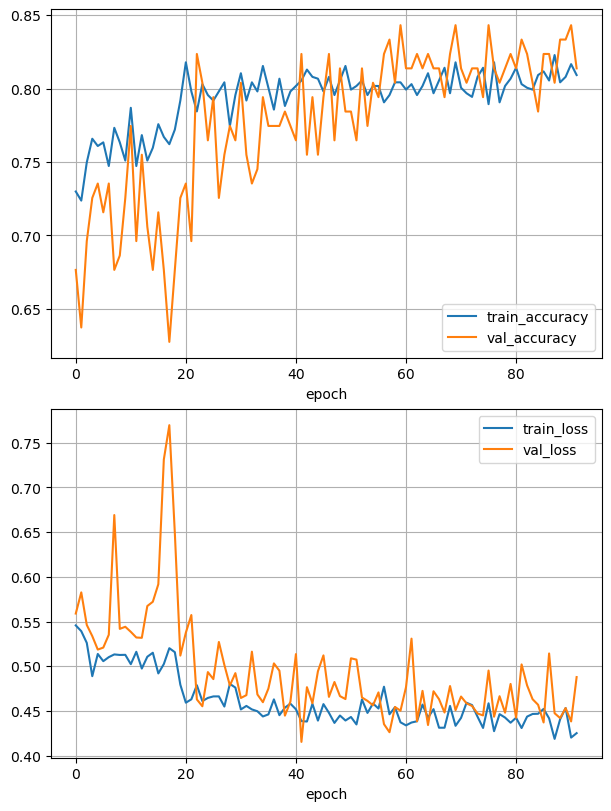

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Calculate and show ROC and AUC.

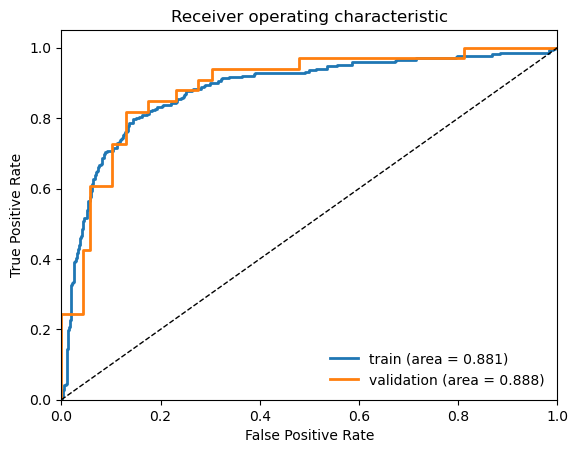

In [13]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [14]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.83
auc 0.928991406603347
aupr 0.8359888485343446
f1 0.679245283018868
precision 0.9
recall 0.5454545454545454
